Try and keep it to cpu rather than gpu
1. have a couple options for embedding styles (pass function into another function)
2. use pillow histogram initially

In [10]:
import pynndescent # https://pynndescent.readthedocs.io/en/latest/how_to_use_pynndescent.html#Nearest-neighbors-of-the-training-set
from PIL import Image # Pillow
import os # for getting filenames

from concurrent.futures import ThreadPoolExecutor # for parallel processing
from tqdm import tqdm # for progress bars

import numpy as np

### Embedding options ###
## VGG16 ##
from torch.utils.data import DataLoader
from dataset import ImageDataset
from torchvision import transforms
import torch
from torchvision import models
## Surf ##
import cv2 as cv


import random

random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)


IMAGE_FOLDER = './images'

# 1. Load images 

consider making sure the way to read through images in flexible (walk through folders), keep zip in same format

In [11]:
image_filenames = np.array(os.listdir(path=IMAGE_FOLDER))
# image_filenames[0:3]

In [12]:
with Image.open(os.path.join(IMAGE_FOLDER, image_filenames[0])) as img:
    print(type(img))
    print(img.histogram()) # Colour histogram
    # display(img)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[217, 100, 132, 391, 942, 4961, 5471, 17856, 107282, 12908, 24153, 20018, 9394, 9325, 4527, 8380, 5716, 4159, 6068, 4032, 5817, 3597, 2669, 2576, 2506, 2141, 2256, 2315, 2209, 2151, 1934, 1732, 1977, 1960, 2162, 1917, 2019, 1884, 1873, 2140, 1991, 2040, 2085, 2014, 2085, 2189, 2122, 2097, 2124, 2047, 2163, 2181, 2084, 2073, 2049, 2104, 2013, 2176, 2185, 2340, 2222, 2356, 2292, 2524, 2464, 2476, 2616, 2742, 2481, 2556, 2684, 2649, 2680, 2707, 2536, 2625, 2658, 2644, 2635, 2644, 2659, 2637, 2724, 2884, 2805, 2814, 2774, 2996, 2809, 2880, 2757, 2863, 2744, 2741, 2698, 2727, 2670, 2835, 2679, 2716, 2664, 2766, 2699, 2717, 2782, 2862, 2812, 2906, 2828, 2804, 2791, 2788, 2671, 2787, 2663, 2720, 2658, 2759, 2660, 2609, 2656, 2680, 2650, 2820, 2818, 2753, 2861, 2784, 2985, 2963, 3078, 3174, 3467, 3280, 3093, 3295, 3388, 3322, 3150, 3047, 2964, 2971, 3169, 3068, 3027, 3152, 3157, 3410, 2997, 3058, 3021, 3329, 3223, 3281, 3245, 3343, 3636, 3729, 3839, 

# 2. "Embedding"
Make a function that takes in a list of filenames and an embedding function and returns "embedding graph"

The format is that the ith row of "embedding" corresponds to the ith filename in image_filenames

In [13]:
def get_descriptors_opencv(f=cv.SIFT_create()):
    # https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format

    def embed(img: "pillow image"):
        open_cv_img = np.array(img.convert('RGB'))[:, :, ::-1].copy()

        # Use sift as surf patented
        # surf = cv.SURF(400) #? add way to change paramts 
        _, des = f.detectAndCompute(open_cv_img,None)

        # Convert RGB to BGR
        return np.array(des).flatten()
    
    return embed


def get_normalised_histogram(img: "pillow image") -> "numpy array":
    """Returns a pixel standardised pillow colour histogram array."""
    w, h = img.size
    pixels = w*h
    return np.array(img.histogram())/pixels

# embedding_function takes a batch of images, get_embedding takes batch_size=
def get_embedding(image_filenames = [], embedding_function = get_normalised_histogram) -> "[embedding_function(img_0),...]":
    """ 
    A function to get embeddings, this does not work well for intensive embeddings which benefit from batching.

    Params:
        - image_filenames: list of filenames within IMAGE_FOLDER.
        - embedding_function: a function which takes in <class 'PIL.JpegImagePlugin.JpegImageFile'>
        and returns a 1D array of floats (by defauly creates colour histogram).

    Returns:
        - embedding: list of embedding where the ith row in embedding.
        corresponds to the ith image_filename in image_filenames.

    #! assumption: assume the order is consistent 
    """

    def process_image(image_filename):
        with Image.open(os.path.join(IMAGE_FOLDER, image_filename)) as img:
            return embedding_function(img) # add the embedding of the image to the given function
        
    with ThreadPoolExecutor() as executor:
        embedding = list(tqdm(executor.map(process_image, image_filenames), total=len(image_filenames)))

    return np.array(embedding) # tqdm does not work without the list()

#### Try to play with pytorch batching

In [45]:
dataset = ImageDataset(image_filenames=image_filenames, root_dir=IMAGE_FOLDER, 
                       transform= transforms.Compose([
                           transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
                           transforms.ToTensor(),         # Convert image to tensor
                           transforms.Normalize(          # Normalize using ImageNet statistics
                            mean=[0.485, 0.456, 0.406],  # Mean for RGB channels
                            std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
                                )
    ]))

dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=4, prefetch_factor=2)

# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

def get_embeddings_pytorch(dataloader, pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")):

    pytorch_model.eval()  # optimization (disable unneeded things)

    torch.set_grad_enabled(False)  # optimization (disable unneeded things)


    batch_embeddings = []  # Using a list to hold embeddings for each image
    batch_filenames = []

    for i_batch, (batch, filenames) in enumerate(dataloader):
    #     print("Start loop:", i_batch)
        
        with torch.no_grad():  # Disable gradient calculations for inference
            output = pytorch_model(batch)

        # The output is logits; apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Convert to numpy array
        probabilities_numpy = probabilities.detach().cpu().numpy()

        print(f'\rCompleted: {i_batch+1}/{len(dataloader)}', end='', flush=True) # overwrite prev update message
        
        # Store each batch's probabilities with corresponding filenames
        batch_embeddings.extend(probabilities_numpy)  # Add probabilities for each image
        batch_filenames.extend(filenames)  # Add corresponding filenames

    return np.array(batch_embeddings), np.array(batch_filenames)

In [46]:
%%time
# #### Get embedding without batching ####
# embedding_function = get_pytorch_embedding_function()
# embedding_function=get_descriptors_opencv()
# embedding = get_embedding(image_filenames=image_filenames, embedding_function=embedding_function) 
# np.save("./output/image_embedding.npy", embedding)
# np.save("./output/image_filenames.npy", image_filenames) # this is to keep a consistent log of the index
# # using ThreadPoolEexecutor speed up from 15s to 3s

#### Get embedding with batching (for pytorch) ####
batch_embeddings, batch_filenames = get_embeddings_pytorch(dataloader)
np.save("./output/image_batch_embeddings.npy", batch_embeddings)
np.save("./output/image_batch_filenames.npy", batch_filenames)
# CPU times: user 5min 35s, sys: 25.6 s, total: 6min
# Wall time: 2min 10s


# embeddding vgg16 all images 
# CPU times: user 3h 48min 31s, sys: 4min 30s, total: 3h 53min 1s
# Wall time: 48min 13s

#* You can read from the saved file by uncommenting this code and commenting above
# embedding = np.load("./output/image_embedding.npy")
# image_filenames = np.load("./output/image_filenames.npy") # to make sure the filename at each index is consistent


embedding = batch_embeddings
image_filenames = batch_filenames

Completed: 16/16CPU times: user 5min 43s, sys: 30.7 s, total: 6min 13s
Wall time: 2min 14s


# 3. Get KNN

In [24]:
def get_knn(embedding, n_neighbours=10) -> ("nearest_neighbours_array", "neighbours_distance_array"):
    """
    Params:
        - embedding: numpy array of embeddings. #? not a great description
        - n_neighbours: number of nearest neighbours returned.

    Returns:
        - nearest_neighbour_array: an array where the ith row corresponds to the n
        nearest neighbours for the ith point.
        - neighbours_distance_array: an array where the ith row corresponds to 
        the distances of the n nearest neighbours from the ith point.
    """
    index = pynndescent.NNDescent(embedding, n_neighbors=n_neighbours)
    return index.neighbor_graph # nearest_neighbours_array, neighbours_distance_array 

In [25]:
%%time
number_of_neighbours = 10
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours.npy", nearest_neighbours_array)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours_distance.npy", neighbours_distance_array)


# #* You can read from the saved file by uncommenting this code and commenting above
# number_of_neighbours_load = 10
# nearest_neighbours_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours.npy")
# neighbours_distance_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours_distance.npy")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 6.83 s, sys: 362 ms, total: 7.2 s
Wall time: 8.29 s


In [26]:
# nearest_neighbours_array, neighbours_distance_array 

# 3.5 Make some analysis helper functions
First some functions for getting the most common neighbours

In [27]:
def get_count_neighbour_occurances(nearest_neighbours_array) -> "ranking_array":
    """return array where the ith index is how many times the ith number occured as a neighbour 
    (including as a neighbour of itself)"""
    _, counts = np.unique(nearest_neighbours_array.flatten(), return_counts=True) 
    return counts

In [28]:
# count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)

In [29]:
def rank_neighbour_occurances(count_neighbour_occurances_array, ascending=True):
    """takes get_count_neighbour_occurances() or get_mean_distance() output as input and returns a ranked array 
    of indexes in desired order (the index corresponds to a filename in the image_filenames variable)"""
    # first part returns ascending list of sorted indices 
    # second part conditionally flips the order
    return np.argsort(count_neighbour_occurances_array)[::-1+2*ascending] # ascending = True -> 1,  ascending = False -> -1


In [30]:
# you can see that the first value in the left array corresponds to the smallest value in the second array etc.
# ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)
# ranked_neighbour_occurances, count_neighbour_occurances_array

now some functions for getting the mean distance of an image from its neighbours

In [31]:
def get_mean_distance(neighbours_distance_array, exclude_self=True):
    """Takes neighbours_distance_array and returns an array where the ith row
    is the mean distance across the n neighbours from the ith embedded image.

    This mean can conditionally include its distance from itself (0) in the mean calculation"""

    if exclude_self:
        mean_distances = np.mean(neighbours_distance_array[:, 1:], axis=1) # exclude first column if exclude_self

    else:
        mean_distances = np.mean(neighbours_distance_array, axis=1)
    return mean_distances

In [32]:
# neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
# neighbours_mean_distance_array, rank_neighbour_occurances(neighbours_mean_distance_array)

## 3.5.1 Doing some graphing
first lets graph the most common neighbours

import dependencies

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

graphing most common neighbours

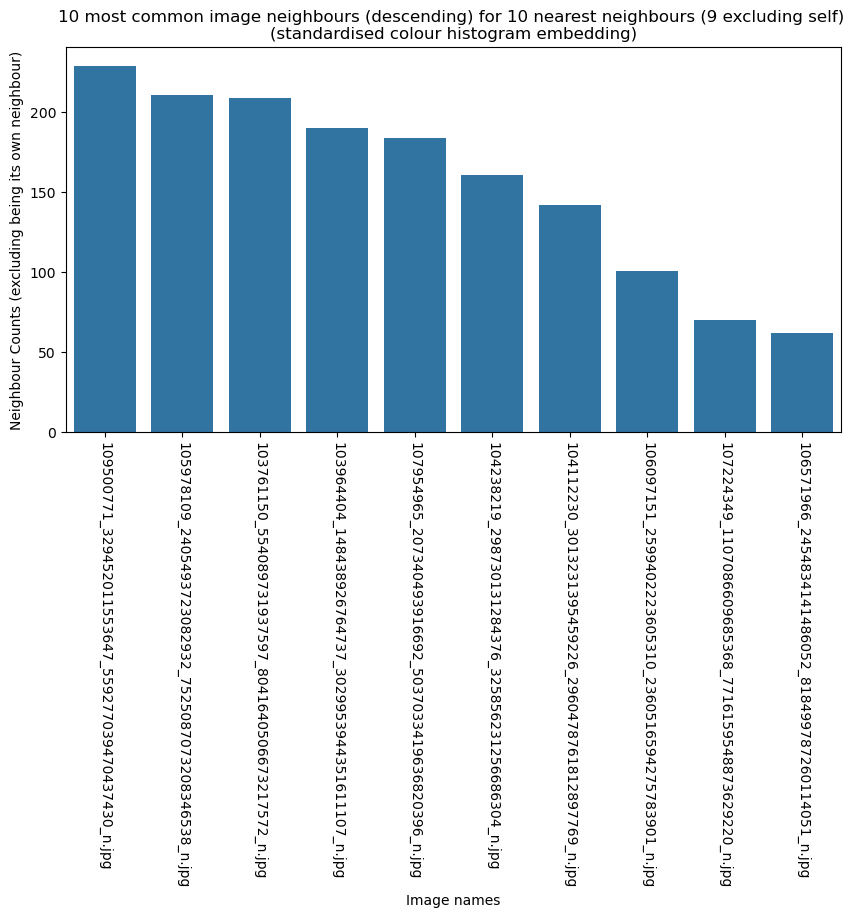

109500771_329452011553647_559277039470437430_n.jpg


In [34]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self) \n(standardised colour histogram embedding)")

plt.show()
print(x[0])

show the top image neighbour

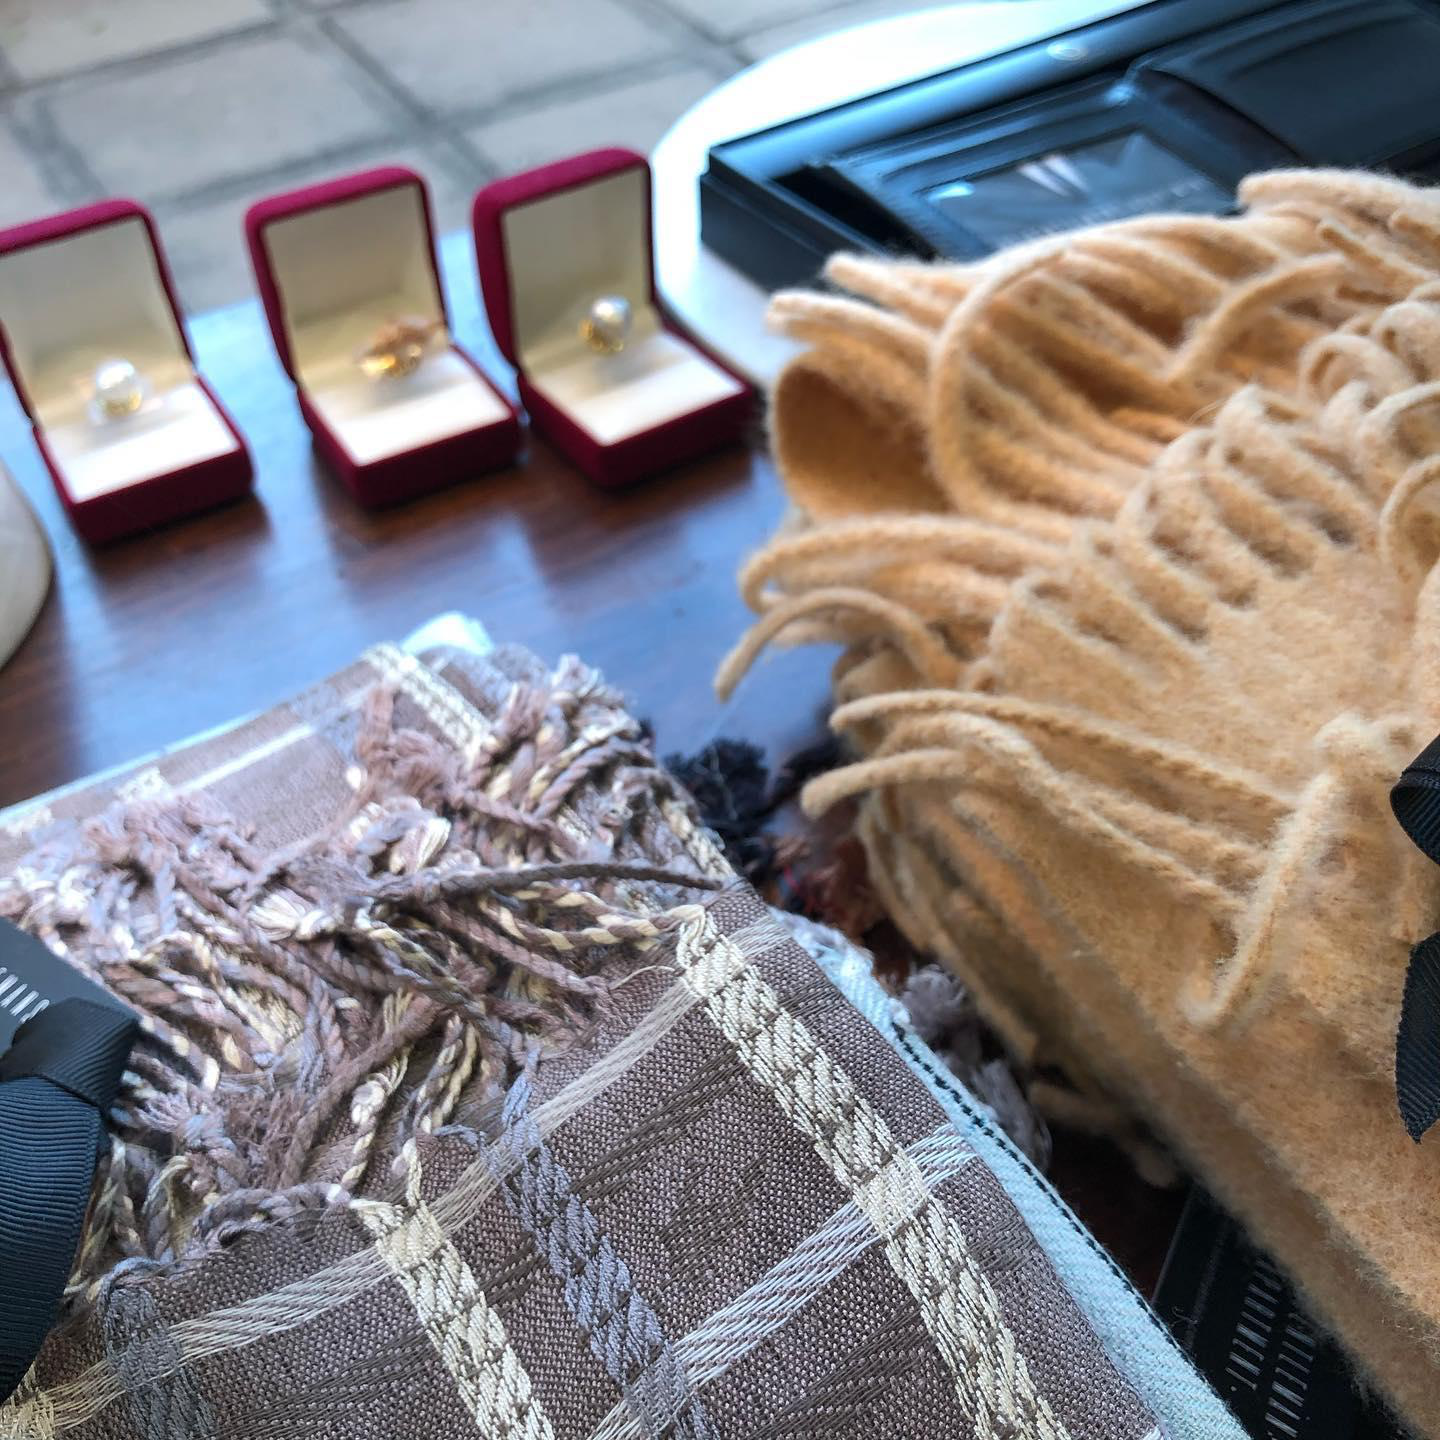

In [35]:
with Image.open(os.path.join(IMAGE_FOLDER, x[0])) as img:
    display(img)

Now lets graph mean distance from neighbours

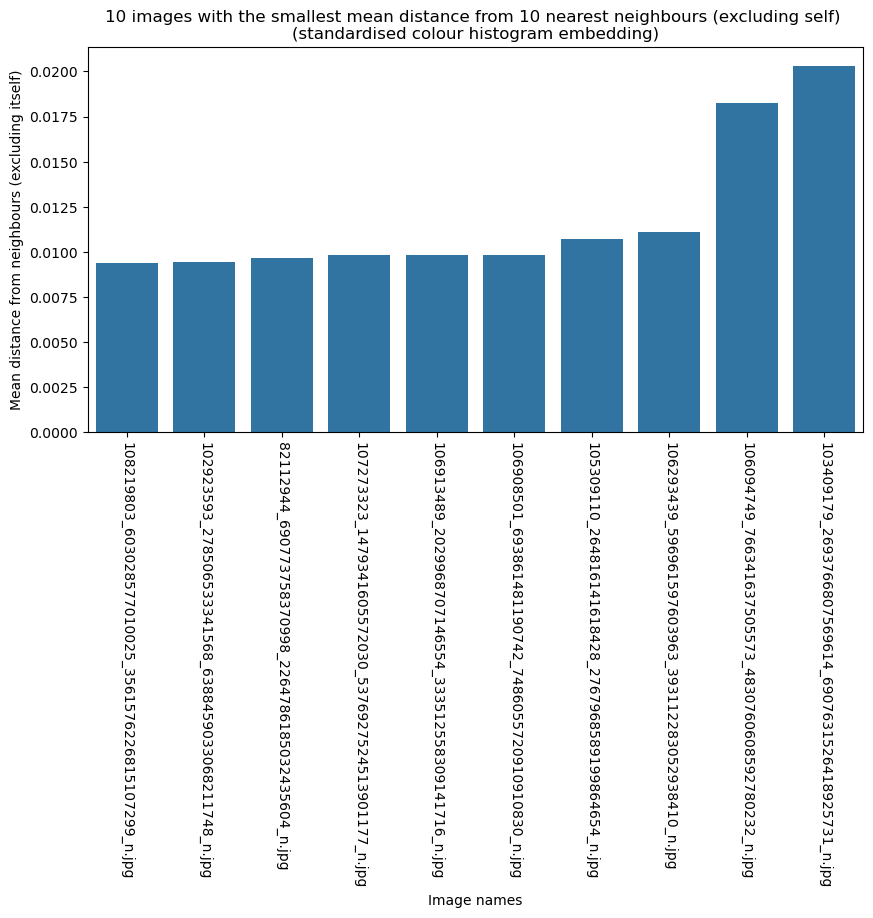

108219803_603028577010025_3561576226815107299_n.jpg


In [36]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
ranked_neighbour_occurances = rank_neighbour_occurances(neighbours_mean_distance_array, ascending=True)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[neighbours_mean_distance_array[idx] for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Mean distance from neighbours (excluding itself)")
plt.title(f"{n_most_common} images with the smallest mean distance from 10 nearest neighbours (excluding self) \n(standardised colour histogram embedding)")

plt.show()
print(x[0])

Show the "closest" neighbour

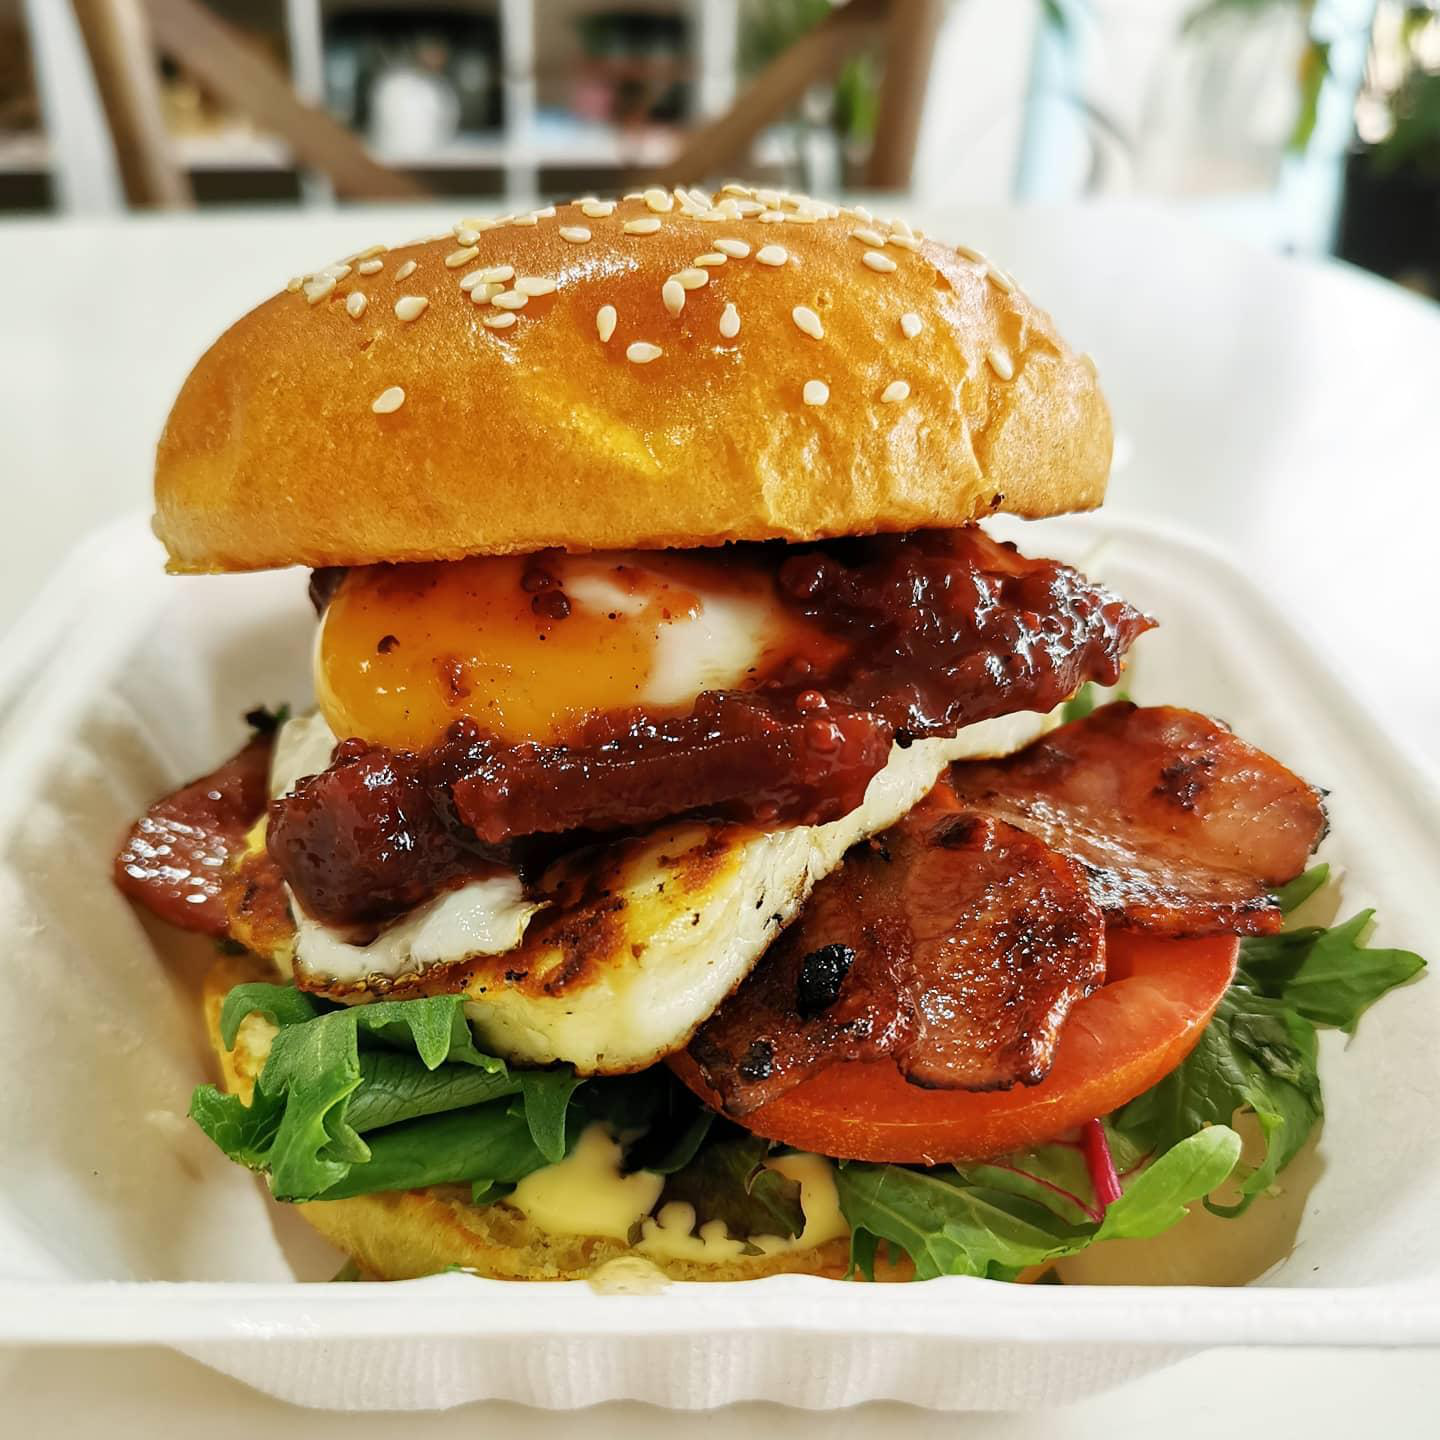

In [37]:
with Image.open(os.path.join(IMAGE_FOLDER, x[0])) as img:
    display(img)

Create a histogram for count of neighbours

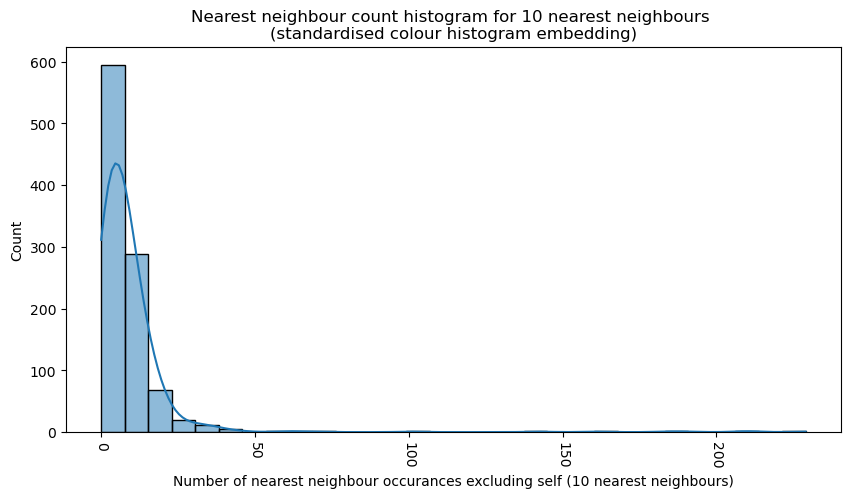

In [38]:
sorted_count_neighbour_occurances_array = np.sort(get_count_neighbour_occurances(nearest_neighbours_array))-1 # -1 to exclude self

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_count_neighbour_occurances_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"Number of nearest neighbour occurances excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"Nearest neighbour count histogram for {number_of_neighbours} nearest neighbours \n(standardised colour histogram embedding)")

plt.show()


# 4. Export 
First to explore, export html document with image, # nearest neighbours sorted top to bottom

In [39]:
#? do something with neighbours_distance_array
def generate_html(nearest_neighbours_array, image_filenames, image_filepath = "../images/"):
    """Generates string html file to display the images and relevant information"""
    count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
    ranked_indices = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)
    number_of_neighbours = len(nearest_neighbours_array[0])


    file_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>New File</title>
</head>
<body>
    <header>
        <h1>File title</h1>
        <!-- Add navigation or header content here -->
    </header>
    <p>You can ⌘+F/Ctrl+F and type <code>(desired index)</code> to find a specific index</p>
    <p>Information here, Images are ranked on their number of times they appear as a nearest neighbour overall. </p>
    <!-- Basic table -->
    <table border="1" style="width:100%;">
        <thead>
            <tr>
                <th>Rank (Index)</th>
                <th>Nearest Neighbour occurances <br/> (excluding self)</th>
                <th>Filename</th>
                <th>{} Nearest Neighbours (indices)</th>
                <th>Image</th>
            </tr>
        </thead>
        <tbody>
            {}
        </tbody>
    </table>

    <footer>
        <p>This is a footer with who made it</p>
    </footer>

</body>
</html>
"""

    row_template = """ 
            <tr>
                <td>{}. ({})</td>
                <td>{}</td>
                <td>{}</td>
                <td>{}</td>
                <td><img src="{}" alt="Image" style="width:200px; height:auto;"></td>
            </tr>"""
    
    table_rows = """"""
    # iterate through the ranks
    # rank = 1 means this image has the most neighbours
    def generate_html_image_module(index, rank):
        """This will generate the html for a given image"""
        # can use index to get filename, nearest_neighbours, and count of nearest neighbours
        
        filename = image_filenames[index]
        nearest_neighbours = nearest_neighbours_array[index]
        count_neighbour_occurances = count_neighbour_occurances_array[index] -1 # -1 to exclude self

        return row_template.format(rank,index, count_neighbour_occurances, filename, ", ".join(map(str, nearest_neighbours)), image_filepath+filename)
    
    # idx in this case is the item in the list, not the index of the item in the list
    # this is an index referencing the other lists
    for rank, idx in enumerate(ranked_indices):
        table_rows += generate_html_image_module(idx, rank+1) # rank starts at 0

    return file_template.format(number_of_neighbours, table_rows)



In [40]:
html_file = generate_html(nearest_neighbours_array, image_filenames)

with open("./output/output.html",'w') as file:
    file.write(html_file)

is the nearest neighbour graph of a specific set of images and embeddings a useful way for navigating/making sense of a dataset



1. histogram for counts of neighbours ✅
2. make a html document with image, number of nearest neighbours, sorted from top to bottom ✅

Embeddings:
- vgg (16) (see if specific package just for vgg) ✅
- yolo (might be more modern/state of the art) 
- check papers sent (single layer feature networks)
- surf feature extractor (implementation in scikit image)

constraints:
- needs to run on windows (no tensorflow?)
- pytorch based things? (pytorch cpu backend)
- need to work on cpu + not be slow
- ~~ coffee break to do initial processing (5-15 for 20 000) (everything else can be interactive so can sit and wait)
- embedding step is linear, knn is ^1.1ish

one of the 

use np standard to write the embedded array and KNN array and the filename array ✅

ideas:
- can do a colour coded histogram for count of neighbours with multiple types of embeddings

Experiment with batching first and see how much it helps, see if it takes advantage of multiple threads natively